In [212]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import os
import numpy as np
import itertools

In [213]:
#Covid Tracking project API
#this works interimittentently presumably due to load on their servers
#@todo wrap function with a retry decorator

daily = pd.read_json("https://covidtracking.com/api/states/daily", orient='records')
daily

,date,state,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease
0,20200401,AK,133.0,4470.0,NaN,9.0,3.0,4603,8f5b266fd8dae5257f0202c567e5214c32a44482,2020-04-01T20:00:00Z,4603,2,0.0,2.0,876.0,14.0,890.0
1,20200401,AL,1077.0,6697.0,NaN,NaN,26.0,7774,dae6ab1cd13e64307365a12f912672d5efa845d8,2020-04-01T20:00:00Z,7774,1,13.0,0.0,399.0,96.0,495.0
2,20200401,AR,584.0,7354.0,NaN,90.0,10.0,7938,a6205f9b023e366a7116d36d2a495b835fd1f322,2020-04-01T20:00:00Z,7938,5,2.0,26.0,1395.0,61.0,1456.0
3,20200401,AS,0.0,20.0,6.0,NaN,0.0,26,737a9ede2746378dfe7a401f0d227ef5419411af,2020-04-01T20:00:00Z,20,60,0.0,0.0,17.0,0.0,17.0
4,20200401,AZ,1413.0,19645.0,NaN,149.0,29.0,21058,29f0e82e800bdc7a40abfd72ed6c629468eea982,2020-04-01T20:00:00Z,21058,4,5.0,71.0,1563.0,124.0,1687.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1480,20200304,OR,3.0,29.0,18.0,NaN,NaN,50,5b37d7f2e6aa9fb39e09270626674b16ce9b5182,2020-03-04T21:00:00Z,32,41,NaN,NaN,NaN,NaN,NaN
1481,20200304,SC,0.0,5.0,0.0,NaN,NaN,5,992c7ca6f8259ac7a323c0b92c27123c671f3773,2020-03-04T21:00:00Z,5,45,NaN,NaN,NaN,NaN,NaN
1482,20200304,TX,1.0,NaN,NaN,NaN,NaN,1,7be175c20e3c9485c14f9764bd90385842df19c3,2020-03-04T21:00:00Z,1,48,NaN,NaN,NaN,NaN,NaN
1483,20200304,WA,39.0,NaN,NaN,NaN,10.0,39,26136397bf1f1556b7662cccc14959755cecc5b3,2020-03-04T21:00:00Z,39,53,NaN,NaN,NaN,NaN,NaN


In [214]:
states = pd.read_json("https://covidtracking.com/api/states", orient='records')

In [215]:
states.set_index("state", drop=True).loc["NY"]

positive                                                            83712
positiveScore                                                           1
negativeScore                                                           1
negativeRegularScore                                                    1
commercialScore                                                         1
grade                                                                   A
score                                                                   4
negative                                                           137168
pending                                                               NaN
hospitalized                                                        18368
death                                                                1941
total                                                              220880
lastUpdateEt                                                   4/01 12:00
checkTimeEt                           

In [216]:
population = pd.read_csv("https://raw.githubusercontent.com/datasets/population/master/data/population.csv")

In [217]:
pop_italy = int(population.loc[population["Country Name"].str.contains("Italy")].tail(1).Value)
pop_sk = int(population.loc[population["Country Name"].str.contains("Korea")].tail(1).Value)
print(pop_italy)
print(pop_sk)

60600590
51245707


In [218]:
daily.date = daily.date.astype("str").apply(pd.to_datetime).dt.date

In [219]:
daily = daily.set_index(["state","date"], drop=True).sort_index()

In [220]:
daily_test_rate = (daily['total']-daily["total"].shift(1))
daily_test_rate.name = "daily_test"
daily = pd.concat([daily, daily_test_rate], axis=1)

In [221]:
daily_last_update = daily.index.get_level_values(1).max().date().strftime("%Y-%m-%d")
daily_last_update

'2020-04-01'

In [222]:
# need to develop a "days since tests scaled" index using either daily rates or use worldindata upper half pop adjusted data
# this file must be manually updated from this page:  https://ourworldindata.org/covid-testing  (per million data)
file = "tests-vs-confirmed-cases-covid-19-per-million.csv"
folder = "c:/users/lee/downloads"
tests_world = pd.read_csv(os.path.join(folder, file))

In [223]:
tests_world_sum = tests_world.dropna(subset=["Total COVID-19 tests per million people", \
                           "Total confirmed cases of COVID-19 per million people (cases per million)"]).\
        groupby("Entity").last()
cols = list(tests_world_sum.columns)
new_cols = ["tests_per_M", "cases_per_M"]
cols = cols[0:2]+ new_cols
tests_world_sum.columns = cols

In [224]:
world_tests_cum_median = tests_world_sum['tests_per_M'].describe()["50%"]
world_tests_cum_median

#use this as benchmark for "scale" testing

602.4000000000001

In [225]:
tests_world_sum

,Code,Year,tests_per_M,cases_per_M
Entity,,,,
Armenia,ARM,57,276.7,26.322592
Australia,AUS,59,4473.4,27.804051
Austria,AUT,59,1777.8,243.826612
Bahrain,BHR,59,10982.1,158.088086
Belarus,BLR,55,1699.3,2.857348
Belgium,BEL,57,1580.0,107.251181
Brazil,BRA,52,13.7,0.362252
Canada,CAN,59,3389.7,22.415253
Colombia,COL,59,81.7,2.515581


In [226]:
cols

['Code', 'Year', 'tests_per_M', 'cases_per_M']

In [227]:
pop = pd.read_csv("http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#")

In [228]:
pop

,SUMLEV,REGION,DIVISION,STATE,NAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,10,0,0,0,United States,308745538,308758105,309321666,311556874,313830990,...,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
1,20,1,0,0,Northeast Region,55317240,55318443,55380134,55604223,55775216,...,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
2,20,2,0,0,Midwest Region,66927001,66929725,66974416,67157800,67336743,...,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
3,20,3,0,0,South Region,114555744,114563030,114866680,116006522,117241208,...,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
4,20,4,0,0,West Region,71945553,71946907,72100436,72788329,73477823,...,0.614245,2.723344,3.062896,3.162262,4.026429,4.987285,5.261078,4.021194,3.044951,2.312083
5,40,3,6,1,Alabama,4779736,4780125,4785437,4799069,4815588,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
6,40,4,9,2,Alaska,710231,710249,713910,722128,730443,...,-12.929847,0.587728,1.416798,-0.955359,-11.460949,-7.997118,-3.897349,-10.992765,-13.859140,-12.031221
7,40,4,8,4,Arizona,6392017,6392288,6407172,6472643,6554978,...,12.609078,4.278167,6.899802,6.376679,9.168478,9.597577,11.964782,10.878879,12.962934,13.687161
8,40,3,7,5,Arkansas,2915918,2916031,2921964,2940667,2952164,...,0.834503,3.294766,0.827785,0.057853,-0.091449,1.075446,1.486269,2.009593,0.958896,0.923429
9,40,4,9,6,California,37253956,37254519,37319502,37638369,37948800,...,-5.151429,1.276797,1.495016,1.649031,2.203551,1.984957,0.500044,-0.629909,-2.130954,-3.276681


In [229]:
key_cols = ['STATE', 'NAME', 'POPESTIMATE2019']
pop_19 = pop[key_cols].set_index(["STATE", "NAME"], drop=True)
pop_19

POPESTIMATE2019
STATE NAME                                 
0     United States               328239523
      Northeast Region             55982803
      Midwest Region               68329004
      South Region                125580448
      West Region                  78347268
1     Alabama                       4903185
2     Alaska                         731545
4     Arizona                       7278717
5     Arkansas                      3017804
6     California                   39512223
8     Colorado                      5758736
9     Connecticut                   3565287
10    Delaware                       973764
11    District of Columbia           705749
12    Florida                      21477737
13    Georgia                      10617423
15    Hawaii                        1415872
16    Idaho                         1787065
17    Illinois                     12671821
18    Indiana                       6732219
19    Iowa                          3155070
20    Kansas                        2913314
21    Kentucky                      4467673
22    Louisiana                     4648794
23    Maine                         1344212
24    Maryland                      6045680
25    Massachusetts                 6892503
26    Michigan                      9986857
27    Minnesota                     5639632
28    Mississippi                   2976149
29    Missouri                      6137428
30    Montana                       1068778
31    Nebraska                      1934408
32    Nevada                        3080156
33    New Hampshire                 1359711
34    New Jersey                    8882190
35    New Mexico                    2096829
36    New York                     19453561
37    North Carolina               10488084
38    North Dakota                   762062
39    Ohio                         11689100
40    Oklahoma                      3956971
41    Oregon                        4217737
42    Pennsylvania                 12801989
44    Rhode Island                  1059361
45    South Carolina                5148714
46    South Dakota                   884659
47    Tennessee                     6829174
48    Texas                        28995881
49    Utah                          3205958
50    Vermont                        623989
51    Virginia                      8535519
53    Washington                    7614893
54    West Virginia                 1792147
55    Wisconsin                     5822434
56    Wyoming                        578759
72    Puerto Rico                   3193694

In [230]:
states_abbrev = pd.read_json("https://gist.githubusercontent.com/mshafrir/2646763/raw/8b0dbb93521f5d6889502305335104218454c2bf/states_titlecase.json")

In [231]:
states_abbrev

,name,abbreviation
0,Alabama,AL
1,Alaska,AK
2,American Samoa,AS
3,Arizona,AZ
4,Arkansas,AR
5,California,CA
6,Colorado,CO
7,Connecticut,CT
8,Delaware,DE
9,District Of Columbia,DC


In [232]:
pop_19 = pop_19.reset_index(0).join(states_abbrev.set_index('name')).set_index("abbreviation")
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
NaN,0,328239523
NaN,0,55982803
NaN,0,68329004
NaN,0,125580448
NaN,0,78347268
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804


In [233]:
pop_19 = pop_19.loc[pop_19.index.dropna()]
pop_19

,STATE,POPESTIMATE2019
abbreviation,,
AL,1,4903185
AK,2,731545
AZ,4,7278717
AR,5,3017804
CA,6,39512223
CO,8,5758736
CT,9,3565287
DE,10,973764
FL,12,21477737


In [234]:
daily = daily.reset_index().join(pop_19, on="state", how = 'inner').set_index(['state', 'date'], drop=True).sort_index()
daily

positive  negative  pending  hospitalized  death  total  \
state date                                                                  
AK    2020-03-06       0.0       8.0      1.0           NaN    NaN      9   
      2020-03-07       0.0      12.0      2.0           NaN    NaN     14   
      2020-03-08       0.0      14.0      6.0           NaN    NaN     20   
      2020-03-09       0.0      23.0      9.0           NaN    NaN     32   
      2020-03-10       0.0      23.0      9.0           NaN    NaN     32   
...                    ...       ...      ...           ...    ...    ...   
WY    2020-03-28      82.0    1475.0      NaN          14.0    0.0   1557   
      2020-03-29      86.0    1554.0      NaN          15.0    0.0   1640   
      2020-03-30      94.0    1840.0      NaN          17.0    0.0   1934   
      2020-03-31     109.0    1999.0      NaN          17.0    0.0   2108   
      2020-04-01     130.0    2218.0      NaN          18.0    0.0   2348   

                                                      hash  \
state date                                                   
AK    2020-03-06  5c553f2d050cd8857b7944f716837c15937624b4   
      2020-03-07  3d9649d9dae2a6ae18e129541d2fe0209bc69f19   
      2020-03-08  c7ef2397eff6730394c12b168abac0e54b5c9836   
      2020-03-09  9db5d084453091149319d1d9b0b4da0010506759   
      2020-03-10  88f4415b80e031d046ac81010d288945657cc7cf   
...                                                    ...   
WY    2020-03-28  44a009ad19612b01340eeb3374d72c76d4db0168   
      2020-03-29  e6365afc2c29afd4168c8d82cd57312427281140   
      2020-03-30  d9248f4719496d11a727bffdb79de0be68822ba5   
      2020-03-31  75efb74bd6f260608ff4de9e62175d22a2481c3d   
      2020-04-01  93873b0eba3fed99ba20b2c8968649e559624537   

                           dateChecked  totalTestResults  fips  deathIncrease  \
state date                                                                      
AK    2020-03-06  2020-03-06T21:00:00Z                 8     2            NaN   
      2020-03-07  2020-03-07T21:00:00Z                12     2            0.0   
      2020-03-08  2020-03-08T20:00:00Z                14     2            0.0   
      2020-03-09  2020-03-09T20:00:00Z                23     2            0.0   
      2020-03-10  2020-03-10T20:00:00Z                23     2            0.0   
...                                ...               ...   ...            ...   
WY    2020-03-28  2020-03-28T20:00:00Z              1557    56            0.0   
      2020-03-29  2020-03-29T20:00:00Z              1640    56            0.0   
      2020-03-30  2020-03-30T20:00:00Z              1934    56            0.0   
      2020-03-31  2020-03-31T20:00:00Z              2108    56            0.0   
      2020-04-01  2020-04-01T20:00:00Z              2348    56            0.0   

                  hospitalizedIncrease  negativeIncrease  positiveIncrease  \
state date                                                                   
AK    2020-03-06                   NaN               NaN               NaN   
      2020-03-07                   0.0               4.0               0.0   
      2020-03-08                   0.0               2.0               0.0   
      2020-03-09                   0.0               9.0               0.0   
      2020-03-10                   0.0               0.0               0.0   
...                                ...               ...               ...   
WY    2020-03-28                   3.0             264.0              12.0   
      2020-03-29                   1.0              79.0               4.0   
      2020-03-30                   2.0             286.0               8.0   
      2020-03-31                   0.0             159.0              15.0   
      2020-04-01                   1.0             219.0              21.0   

                  totalTestResultsIncrease  daily_test  STATE  POPESTIMATE2019  
state date                                                 

In [235]:
daily.loc["NY"]

,positive,negative,pending,hospitalized,death,total,hash,dateChecked,totalTestResults,fips,deathIncrease,hospitalizedIncrease,negativeIncrease,positiveIncrease,totalTestResultsIncrease,daily_test,STATE,POPESTIMATE2019
date,,,,,,,,,,,,,,,,,,
2020-03-04,6.0,48.0,24.0,NaN,NaN,78,1afd6e025157a38728847bbf42145c63b024c387,2020-03-04T21:00:00Z,54,36,NaN,NaN,NaN,NaN,NaN,-12720.0,36,19453561
2020-03-05,22.0,76.0,24.0,NaN,NaN,122,25c15099a4116ff026c04c0b4a6b3780ccba310b,2020-03-05T21:00:00Z,98,36,0.0,0.0,28.0,16.0,44.0,44.0,36,19453561
2020-03-06,33.0,92.0,236.0,NaN,NaN,361,1bd1fecfd3d23311c604ac6c27d05ce5835af2c5,2020-03-06T21:00:00Z,125,36,0.0,0.0,16.0,11.0,27.0,239.0,36,19453561
2020-03-07,76.0,92.0,236.0,NaN,NaN,404,d9b32dfe41c22decc86fe0a35515525a18b68fa9,2020-03-07T21:00:00Z,168,36,0.0,0.0,0.0,43.0,43.0,43.0,36,19453561
2020-03-08,105.0,92.0,NaN,NaN,NaN,197,22912a8c6cdefd796b1412292c796959a8cc088f,2020-03-08T20:00:00Z,197,36,0.0,0.0,0.0,29.0,29.0,-207.0,36,19453561
2020-03-09,142.0,92.0,NaN,NaN,NaN,234,917b6249196222819cd69f60c3660aa7e4527b2b,2020-03-09T20:00:00Z,234,36,0.0,0.0,0.0,37.0,37.0,37.0,36,19453561
2020-03-10,173.0,92.0,NaN,NaN,NaN,265,4a5c3cc848789d1ad8988ed7e0b5d3685146d13e,2020-03-10T20:00:00Z,265,36,0.0,0.0,0.0,31.0,31.0,31.0,36,19453561
2020-03-11,216.0,92.0,NaN,NaN,NaN,308,b25e6d0e621fd1fde43a17ce7295e57200236679,2020-03-11T20:00:00Z,308,36,0.0,0.0,0.0,43.0,43.0,43.0,36,19453561
2020-03-12,216.0,92.0,NaN,NaN,NaN,308,d57b4b9097165e7d21987a2f82a772b1bdce4d81,2020-03-12T20:00:00Z,308,36,0.0,0.0,0.0,0.0,0.0,0.0,36,19453561


In [236]:
daily.daily_test.sum()

75429.0

In [237]:
daily_per_capita_M = daily[['positive', 'negative', 'pending', 'death', 'total', 'daily_test']].div(daily.POPESTIMATE2019/1000000
                                                                 , axis=0)
daily_per_capita_M

positive     negative    pending  death        total  \
state date                                                                 
AK    2020-03-06    0.000000    10.935759   1.366970    NaN    12.302729   
      2020-03-07    0.000000    16.403639   2.733940    NaN    19.137579   
      2020-03-08    0.000000    19.137579   8.201819    NaN    27.339398   
      2020-03-09    0.000000    31.440308  12.302729    NaN    43.743037   
      2020-03-10    0.000000    31.440308  12.302729    NaN    43.743037   
...                      ...          ...        ...    ...          ...   
WY    2020-03-28  141.682462  2548.556480        NaN    0.0  2690.238942   
      2020-03-29  148.593802  2685.055438        NaN    0.0  2833.649239   
      2020-03-30  162.416481  3179.216220        NaN    0.0  3341.632700   
      2020-03-31  188.334004  3453.941969        NaN    0.0  3642.275973   
      2020-04-01  224.618537  3832.337812        NaN    0.0  4056.956350   

                  daily_test  
state date                    
AK    2020-03-06         NaN  
      2020-03-07    6.834850  
      2020-03-08    8.201819  
      2020-03-09   16.403639  
      2020-03-10    0.000000  
...                      ...  
WY    2020-03-28  476.882433  
      2020-03-29  143.410297  
      2020-03-30  507.983461  
      2020-03-31  300.643273  
      2020-04-01  414.680376  

[1389 rows x 6 columns]

In [238]:
daily_per_capita_M["rolling_test_3d"] = daily_per_capita_M.groupby(level=0).rolling(3).mean()['daily_test'].\
    reset_index(0, drop=True)

In [239]:
daily_limit = 200 # 200/M was rate at which South Korea hit after ramping testing.   
cum_mask = daily_per_capita_M["total"]>=world_tests_cum_median
daily_mask = daily_per_capita_M['rolling_test_3d'] >=daily_limit
daily_per_capita_M["bool"] = daily_mask | cum_mask
daily_per_capita_M

positive     negative    pending  death        total  \
state date                                                                 
AK    2020-03-06    0.000000    10.935759   1.366970    NaN    12.302729   
      2020-03-07    0.000000    16.403639   2.733940    NaN    19.137579   
      2020-03-08    0.000000    19.137579   8.201819    NaN    27.339398   
      2020-03-09    0.000000    31.440308  12.302729    NaN    43.743037   
      2020-03-10    0.000000    31.440308  12.302729    NaN    43.743037   
...                      ...          ...        ...    ...          ...   
WY    2020-03-28  141.682462  2548.556480        NaN    0.0  2690.238942   
      2020-03-29  148.593802  2685.055438        NaN    0.0  2833.649239   
      2020-03-30  162.416481  3179.216220        NaN    0.0  3341.632700   
      2020-03-31  188.334004  3453.941969        NaN    0.0  3642.275973   
      2020-04-01  224.618537  3832.337812        NaN    0.0  4056.956350   

                  daily_test  rolling_test_3d   bool  
state date                                            
AK    2020-03-06         NaN              NaN  False  
      2020-03-07    6.834850              NaN  False  
      2020-03-08    8.201819              NaN  False  
      2020-03-09   16.403639        10.480103  False  
      2020-03-10    0.000000         8.201819  False  
...                      ...              ...    ...  
WY    2020-03-28  476.882433       321.953237   True  
      2020-03-29  143.410297       308.130558   True  
      2020-03-30  507.983461       376.092064   True  
      2020-03-31  300.643273       317.345677   True  
      2020-04-01  414.680376       407.769037   True  

[1389 rows x 8 columns]

In [240]:
def ret_ndx(s):
    if s.any():
        n = s.shape[0]
        ndx = s.idxmax()
        ptr = s.index.get_loc(ndx)
        arr = list(np.arange(0, n-ptr))
        fill_len = n- len(arr)
        fill = [None]*fill_len
        fill.extend(arr)
        return pd.Series(fill, s.index)
    else: return pd.Series(index=s.index)
    
    

In [241]:
g = daily_per_capita_M.groupby(level=0)['bool']
new_col = g.apply(ret_ndx)

In [242]:
daily_per_capita_M['test_scale_ndx'] = new_col
daily_per_capita_M.loc["FL"]

,positive,negative,pending,death,total,daily_test,rolling_test_3d,bool,test_scale_ndx
date,,,,,,,,,
2020-03-04,0.093120,1.117436,0.744957,NaN,1.955513,-202.116266,NaN,False,NaN
2020-03-05,0.419039,1.443355,3.212629,NaN,5.075023,3.119509,NaN,False,NaN
2020-03-06,0.419039,2.560791,2.374552,NaN,5.354382,0.279359,-66.239132,False,NaN
2020-03-07,0.651838,4.655984,4.097266,NaN,9.405088,4.050706,2.483191,False,NaN
2020-03-08,0.791517,5.494061,5.028463,NaN,11.314041,1.908953,2.079673,False,NaN
2020-03-09,0.838077,6.518378,5.354382,NaN,12.710836,1.396795,2.452152,False,NaN
2020-03-10,0.884637,10.336284,7.216775,NaN,18.437697,5.726860,3.010870,False,NaN
2020-03-11,1.303676,14.014512,6.844296,0.093120,22.162484,3.724787,3.616148,False,NaN
2020-03-12,1.489915,14.014512,6.844296,0.093120,22.348723,0.186239,3.212629,False,NaN


In [243]:
states_scaling = daily_per_capita_M.reset_index(1)['bool'].groupby(level=0).any()
states_scaling
# states testing at scale levels either cumulatively or on a daily basis

state
AK     True
AL     True
AR     True
AZ     True
CA     True
CO     True
CT     True
DE     True
FL     True
GA     True
HI     True
IA     True
ID     True
IL     True
IN     True
KS     True
KY     True
LA     True
MA     True
MD     True
ME     True
MI     True
MN     True
MO     True
MS     True
MT     True
NC     True
ND     True
NE     True
NH     True
NJ     True
NM     True
NV     True
NY     True
OH     True
OK    False
OR     True
PA     True
PR     True
RI     True
SC     True
SD     True
TN     True
TX     True
UT     True
VA     True
VT     True
WA     True
WI     True
WV     True
WY     True
Name: bool, dtype: bool

In [244]:
testing_per_capita = daily_per_capita_M.groupby(level=0).last().\
    sort_values("total", ascending=False)[['total', 'rolling_test_3d']]
testing_per_capita
# south korea scaled up to around 200-300 tests per million people.  200 at scale
# I later realized that total is cumulative.  so, had to add a daily_test delta line.   this is average of last 3 days of tests.

,total,rolling_test_3d
state,,
NY,11354.219415,831.381634
LA,9846.854905,1283.845516
WA,8693.490506,306.154444
MA,7506.416755,612.839777
VT,7203.652628,424.152776
UT,6602.394666,745.902889
HI,6319.074041,457.433064
NM,6314.296492,355.139435
AK,6292.162478,578.228270


Text(0.5, 0, 'Total Confirmed Cases of Covid19 Per Million People')

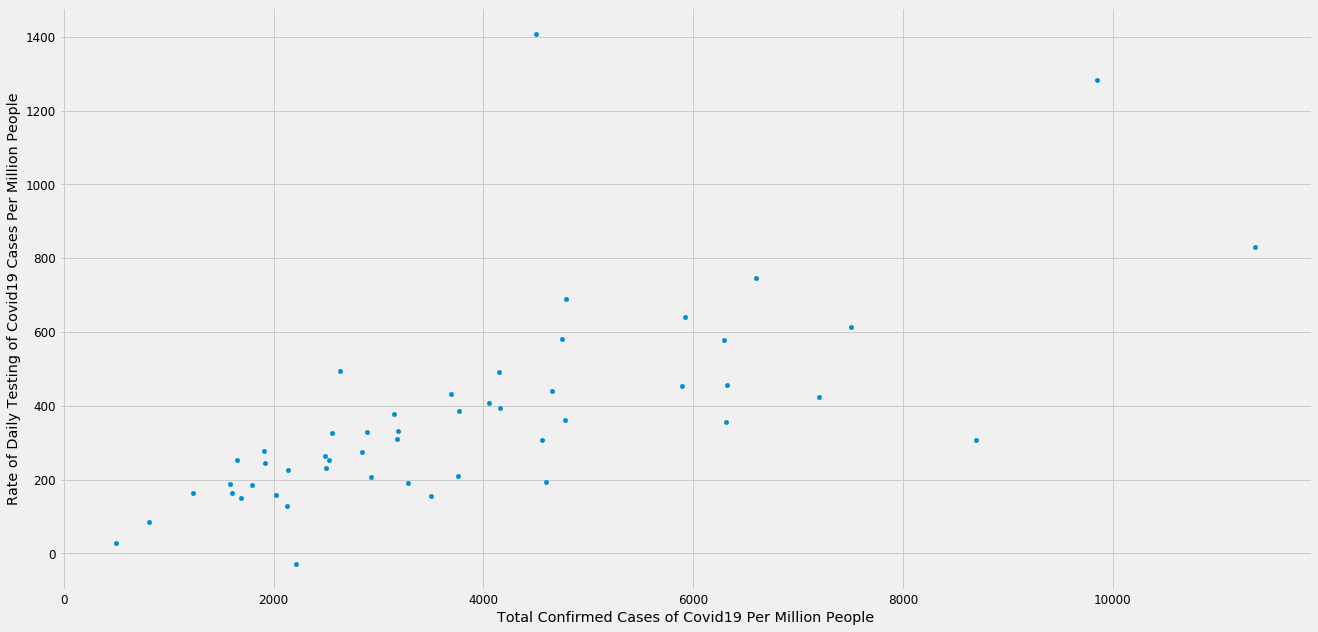

In [245]:
f, ax = plt.subplots(figsize=(20,10))
testing_per_capita.plot.scatter(x='total', y='rolling_test_3d', ax=ax)
ax.set_ylabel("Rate of Daily Testing of Covid19 Cases Per Million People")
ax.set_xlabel("Total Confirmed Cases of Covid19 Per Million People")

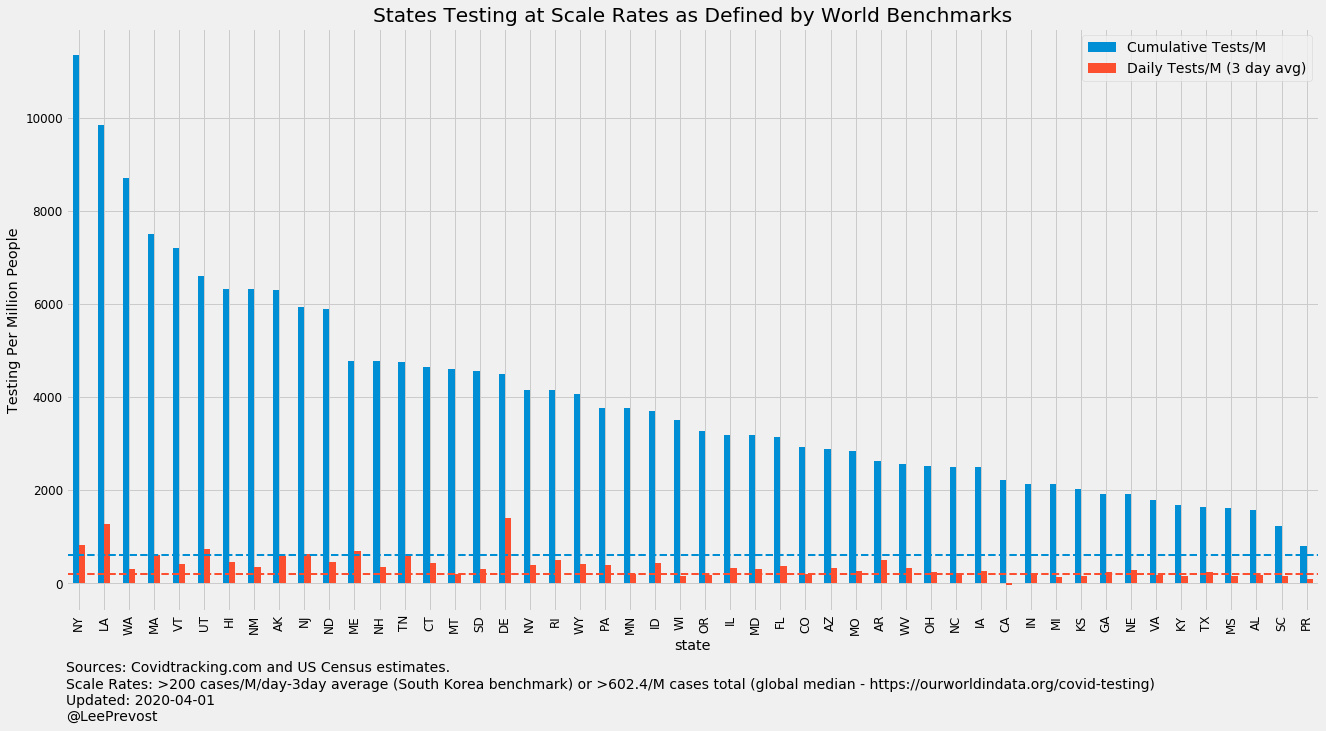

In [246]:
f, ax = plt.subplots(figsize= (20,10))
plt.style.use("fivethirtyeight")
title = "States Testing at Scale Rates as Defined by World Benchmarks"
states_testing_top = testing_per_capita.loc[states_scaling].sort_values(by="total", ascending=False)
ax.set_title(title)
ax.set_ylabel("Testing Per Million People")

label=["Cumulative Tests/M", "Daily Tests/M (3 day avg)"]
states_testing_top.plot(kind='bar', ax=ax, label=label)
colors = colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax.legend(label)
lw=2
ax.axhline(world_tests_cum_median, color = colors[0], linestyle='--', linewidth=lw)
ax.axhline(daily_limit,color=colors[1], linestyle="--", linewidth=lw)
note = """Sources: Covidtracking.com and US Census estimates.
Scale Rates: >200 cases/M/day-3day average (South Korea benchmark) or >602.4/M cases total (global median - https://ourworldindata.org/covid-testing)
Updated: {}
@LeePrevost""".format(daily_last_update)
plt.annotate(note, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("{}.jpg".format(title), bbox_inches='tight')

In [247]:

positives = daily_per_capita_M.loc[states_testing_top.index].reset_index().groupby('state').last()['positive']
positives

state
AK     181.806998
AL     219.653144
AR     193.518201
AZ     194.127619
CA     206.391830
CO     515.043579
CT     997.675643
DE     377.914977
FL     323.823688
GA     436.829163
HI     146.905935
IA     174.005648
ID     293.777786
IL     550.828488
IN     381.003648
KS     165.447322
KY     132.283630
LA    1381.863769
MA    1122.669080
MD     328.333620
ME     255.912014
MI     934.628382
MN     122.171092
MO     257.599763
MS     360.533024
MT     194.614784
NC     151.028539
ND     186.336545
NE     108.560345
NH     305.211916
NJ    2505.575765
NM     150.226843
NV     415.238709
NY    4303.171024
OH     217.895304
OR     163.594838
PA     453.445164
PR      89.551472
RI     534.284347
SC     251.130671
SD     145.818897
TN     392.873282
TX     137.847165
UT     315.662276
VA     173.861718
VT     514.432145
WA     739.865944
WI     266.211691
WV     106.576079
WY     224.618537
Name: positive, dtype: float64

In [248]:
positive = daily_per_capita_M.loc[states_testing_top.index].groupby(level=0).last()['positive'].sort_values(ascending=False)
positive_3d_lag = daily_per_capita_M.loc[states_testing_top.index].groupby(level=0).shift(3).groupby(level=0).last()['positive']

In [249]:
positive_3d_lag

state
AK     139.430930
AL     164.382947
AR     141.162249
AZ     126.258515
CA     144.461626
CO     357.891037
CT     559.001281
DE     238.250747
FL     197.693081
GA     249.683939
HI     106.648059
IA     106.495260
ID     146.049528
IL     362.694517
IN     224.888703
KS     109.497294
KY      88.189086
LA     761.487818
MA     718.897039
MD     204.939726
ME     188.214359
MI     549.321974
MN      89.190217
MO     136.539280
MS     254.691549
MT     144.089792
NC      99.160152
ND     128.598460
NE      55.831035
NH     157.386386
NJ    1507.060759
NM     113.027815
NV     239.598254
NY    3059.234245
OH     141.413796
OR     129.927494
PA     265.115054
PR      39.765864
RI     277.525791
SC     150.328801
SD     101.734115
TN     225.063822
TX      88.012501
UT     224.269937
VA     104.270168
VT     376.609203
WA     565.996134
WI     190.985419
WV      63.052863
WY     148.593802
Name: positive, dtype: float64

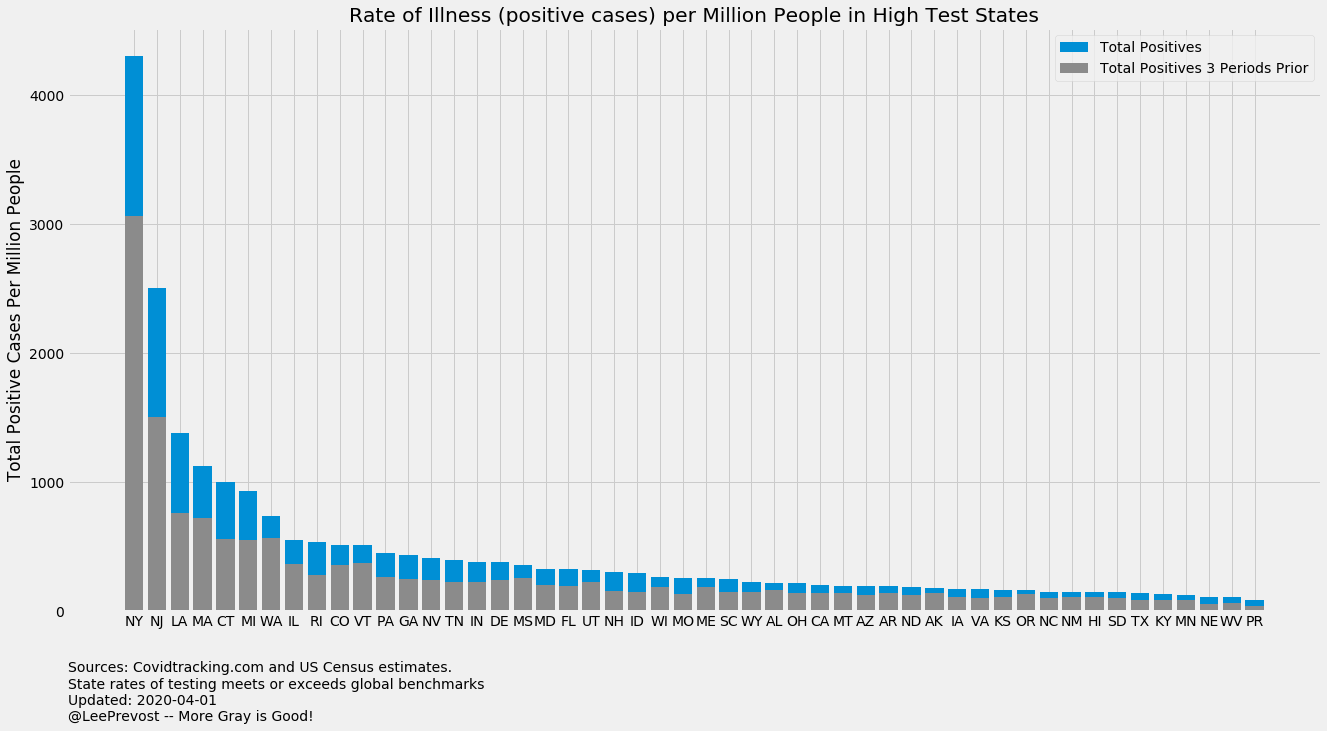

In [250]:
f, ax = plt.subplots(figsize=(20,10))
title = """Rate of Illness (positive cases) per Million People in High Test States"""
ax.bar(positive.index, positive.values)
ax.bar(positive_3d_lag.index, positive_3d_lag.values, color='#8b8b8b')

ax.set_title(title)
ax.set_ylabel("Total Positive Cases Per Million People")
label = ["Total Positives", "Total Positives 3 Periods Prior"]
ax.legend(label)
note = """Sources: Covidtracking.com and US Census estimates.
State rates of testing meets or exceeds global benchmarks
Updated: {}
@LeePrevost -- More Gray is Good!""".format(daily_last_update)
plt.annotate(note, (0,0), (0, -50), xycoords='axes fraction', textcoords='offset points', va='top')
plt.savefig("{}.jpg".format(title), bbox_inches='tight')

In [251]:
colors

['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c']

In [252]:
#pull in South Korea data
Confirmed = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
Deaths = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
Recovered = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"

files = {"Confirmed": Confirmed,
        "Deaths": Deaths,
        "Recovered": Recovered}

for k,v in files.items():
    df = pd.read_csv(v)
    files.update({k: df})
    
confirmed= files['Confirmed']
deaths = files['Deaths']
recovered = files['Recovered']
sit_report = pd.concat([confirmed, deaths, recovered], keys = files.keys())
sit_report = sit_report.reset_index().set_index(["Country/Region", 'level_0']).iloc[:, 4:].T
sit_report.index.name = "Day"
ndx = pd.to_datetime(sit_report.index)
sit_report = sit_report.set_index(ndx)

In [253]:
sit_report

Country/Region Afghanistan   Albania   Algeria   Andorra    Angola  \
level_0          Confirmed Confirmed Confirmed Confirmed Confirmed   
Day                                                                  
2020-01-22               0         0         0         0         0   
2020-01-23               0         0         0         0         0   
2020-01-24               0         0         0         0         0   
2020-01-25               0         0         0         0         0   
2020-01-26               0         0         0         0         0   
...                    ...       ...       ...       ...       ...   
2020-03-27             110       186       409       267         4   
2020-03-28             110       197       454       308         5   
2020-03-29             120       212       511       334         7   
2020-03-30             170       223       584       370         7   
2020-03-31             174       243       716       376         7   

Country/Region Antigua and Barbuda Argentina   Armenia Australia            \
level_0                  Confirmed Confirmed Confirmed Confirmed Confirmed   
Day                                                                          
2020-01-22                       0         0         0         0         0   
2020-01-23                       0         0         0         0         0   
2020-01-24                       0         0         0         0         0   
2020-01-25                       0         0         0         0         0   
2020-01-26                       0         0         0         0         3   
...                            ...       ...       ...       ...       ...   
2020-03-27                       7       589       329        62      1405   
2020-03-28                       7       690       407        71      1617   
2020-03-29                       7       745       424        77      1791   
2020-03-30                       7       820       482        78      2032   
2020-03-31                       7      1054       532        80      2032   

Country/Region  ...      Laos    Kosovo     Burma United Kingdom            \
level_0         ... Recovered Recovered Recovered      Recovered Recovered   
Day             ...                                                          
2020-01-22      ...         0         0         0              0         0   
2020-01-23      ...         0         0         0              0         0   
2020-01-24      ...         0         0         0              0         0   
2020-01-25      ...         0         0         0              0         0   
2020-01-26      ...         0         0         0              0         0   
...             ...       ...       ...       ...            ...       ...   
2020-03-27      ...         0         1         0              0         0   
2020-03-28      ...         0         1         0              0         0   
2020-03-29      ...         0         1         0              0         0   
2020-03-30      ...         0         1         0              0         0   
2020-03-31      ...         0         6         0              0         0   

Country/Region           MS Zaandam  Botswana   Burundi Sierra Leone  
level_0        Recovered  Recovered Recovered Recovered    Recovered  
Day                                                                   
2020-01-22             0          0         0         0            0  
2020-01-23             0          0         0         0            0  
2020-01-24             0          0         0         0            0  
2020-01-25             0          0         0         0            0  
2020-01-26             0          0         0         0            0  
...                  ...        ...       ...       ...          ...  
2020-03-27             0          0         0         0            0  
2020-03-28             0          0         0         0            0  
2020-03-29             0          0         0       

In [254]:
date_start = pd.datetime(2020, 3, 4)   #allows global data to synch with start of US data

In [255]:
sit_report.columns.get_level_values(0).str.contains("Korea")

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [256]:
italy_filt = sit_report.columns.get_level_values(0) == "Italy"
italy = sit_report.loc[:, italy_filt]
print(italy.head())

Country/Region     Italy                 
level_0        Confirmed Deaths Recovered
Day                                      
2020-01-22             0      0         0
2020-01-23             0      0         0
2020-01-24             0      0         0
2020-01-25             0      0         0
2020-01-26             0      0         0


In [257]:
sk_filt = sit_report.columns.get_level_values(0).str.contains("Korea")
sk = sit_report.loc[:,sk_filt]
print(sk.head())

Country/Region Korea, South                 
level_0           Confirmed Deaths Recovered
Day                                         
2020-01-22                1      0         0
2020-01-23                1      0         0
2020-01-24                2      0         0
2020-01-25                2      0         0
2020-01-26                3      0         0


In [258]:
italy_pop = (italy/pop_italy)*1e6
sk_pop = (sk/pop_sk)*1e6

In [259]:
sk_pop

Country/Region Korea, South                      
level_0           Confirmed    Deaths   Recovered
Day                                              
2020-01-22         0.019514  0.000000    0.000000
2020-01-23         0.019514  0.000000    0.000000
2020-01-24         0.039028  0.000000    0.000000
2020-01-25         0.039028  0.000000    0.000000
2020-01-26         0.058541  0.000000    0.000000
...                     ...       ...         ...
2020-03-27       182.103059  2.712422   88.358621
2020-03-28       184.952078  2.809991   93.881035
2020-03-29       187.001030  2.966102   98.213105
2020-03-30       188.523109  3.083185  102.018302
2020-03-31       190.962338  3.161240  105.530791

[70 rows x 3 columns]

In [260]:
filt = sk_pop.columns.get_level_values(1)=='Confirmed'
sk_confirmed = sk_pop.loc[:, filt]
#sk_confirmed = sk_confirmed.to_frame()

In [261]:
filt = italy_pop.columns.get_level_values(1)=="Confirmed"
italy_confirmed = italy_pop.loc[:, filt]

In [262]:
sk_confirmed.columns = ["South Korea"]
#limit to US dates
sk_confirmed_filt = sk_confirmed.loc[sk_confirmed.index>= date_start]
italy_confirmed_filt = italy_confirmed[italy_confirmed.index>=date_start]

In [263]:
daily_per_capita_M.replace(0,pd.np.nan)

positive     negative    pending  death        total  \
state date                                                                 
AK    2020-03-06         NaN    10.935759   1.366970    NaN    12.302729   
      2020-03-07         NaN    16.403639   2.733940    NaN    19.137579   
      2020-03-08         NaN    19.137579   8.201819    NaN    27.339398   
      2020-03-09         NaN    31.440308  12.302729    NaN    43.743037   
      2020-03-10         NaN    31.440308  12.302729    NaN    43.743037   
...                      ...          ...        ...    ...          ...   
WY    2020-03-28  141.682462  2548.556480        NaN    NaN  2690.238942   
      2020-03-29  148.593802  2685.055438        NaN    NaN  2833.649239   
      2020-03-30  162.416481  3179.216220        NaN    NaN  3341.632700   
      2020-03-31  188.334004  3453.941969        NaN    NaN  3642.275973   
      2020-04-01  224.618537  3832.337812        NaN    NaN  4056.956350   

                  daily_test  rolling_test_3d   bool  test_scale_ndx  
state date                                                            
AK    2020-03-06         NaN              NaN  False             NaN  
      2020-03-07    6.834850              NaN  False             NaN  
      2020-03-08    8.201819              NaN  False             NaN  
      2020-03-09   16.403639        10.480103  False             NaN  
      2020-03-10         NaN         8.201819  False             NaN  
...                      ...              ...    ...             ...  
WY    2020-03-28  476.882433       321.953237   True             8.0  
      2020-03-29  143.410297       308.130558   True             9.0  
      2020-03-30  507.983461       376.092064   True            10.0  
      2020-03-31  300.643273       317.345677   True            11.0  
      2020-04-01  414.680376       407.769037   True            12.0  

[1389 rows x 9 columns]

In [264]:
daily_per_capita_M.loc["OK"]

,positive,negative,pending,death,total,daily_test,rolling_test_3d,bool,test_scale_ndx
date,,,,,,,,,
2020-03-07,0.252719,NaN,NaN,NaN,0.252719,-7464.800728,NaN,False,NaN
2020-03-08,0.252719,2.021748,0.505437,NaN,2.779904,2.527186,NaN,False,NaN
2020-03-09,0.252719,2.021748,2.527186,NaN,4.801653,2.021748,-2486.750598,False,NaN
2020-03-10,0.505437,3.790778,2.779904,NaN,7.076120,2.274467,2.274467,False,NaN
2020-03-11,0.505437,3.790778,2.779904,NaN,7.076120,0.000000,1.432072,False,NaN
2020-03-12,0.758156,9.097868,1.010874,NaN,10.866898,3.790778,2.021748,False,NaN
2020-03-13,0.758156,9.097868,9.350587,NaN,19.206610,8.339712,4.043497,False,NaN
2020-03-14,1.010874,9.097868,9.350587,NaN,19.459329,0.252719,4.127736,False,NaN
2020-03-15,2.274467,29.820790,3.032623,NaN,35.127879,15.668551,8.086994,False,NaN


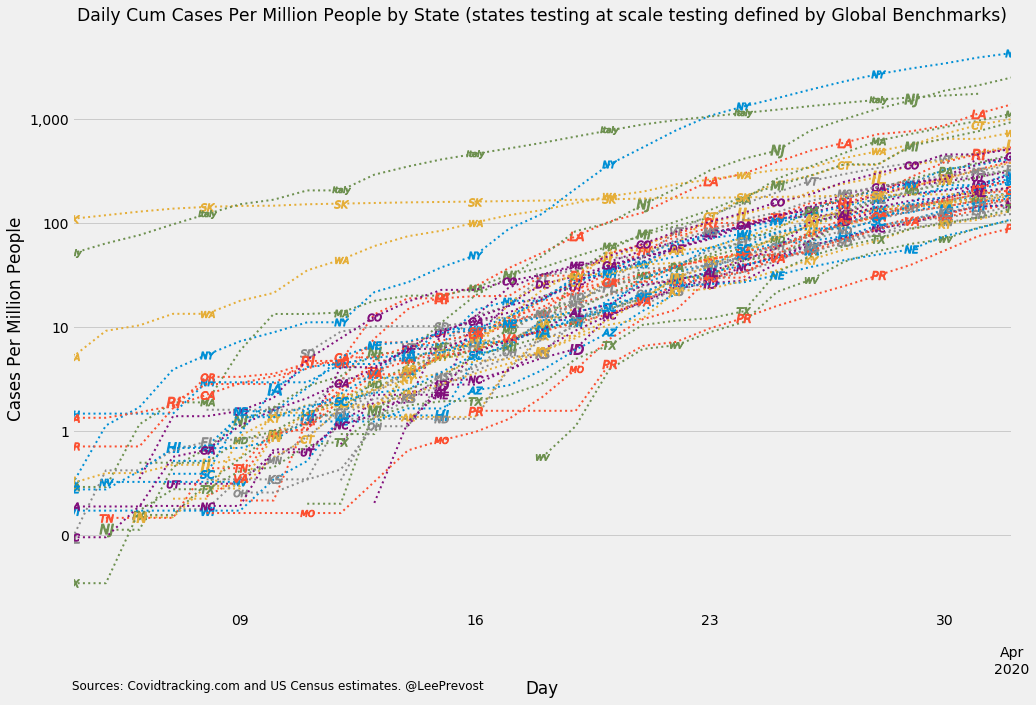

In [265]:

f, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({"font.size": 12})
#plt.style.use("seaborn")
lines = dict(legend=False, markersize=14, ax=ax, linewidth=2, markevery=4, logy=True, linestyle='dotted')

for ndx, state in enumerate(states_testing_top.index):
    daily_per_capita_M.replace(0, pd.np.nan).loc[states_testing_top.index[ndx]]['positive'].\
        plot(label=state, marker='${}$'.format(state), **lines)
    
sk_confirmed_filt.plot(label="South Korea", marker='$SK$', **lines)
lines.pop("markersize")
italy_confirmed_filt.plot(label="Italy", marker='$Italy$', markersize=18, **lines)
ax.set_ylabel("Cases Per Million People")
note = """Sources: Covidtracking.com and US Census estimates. @LeePrevost"""
plt.annotate(note, (0,0), (0, -70), xycoords='axes fraction', textcoords='offset points', va='top')
title = "Daily Cum Cases Per Million People by State (states testing at scale testing defined by Global Benchmarks)"
plt.title(title)
ax.get_yaxis().set_major_formatter(
    tick.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("{}.jpg".format(title), bbox_inches='tight')

In [266]:
positive_since_testing = daily_per_capita_M.dropna(subset=["test_scale_ndx"]).reset_index().set_index(["state", "test_scale_ndx"])['positive']
positive_since_testing = positive_since_testing.to_frame().unstack().T.reset_index(0)
positive_since_testing

state,level_0,AK,AL,AR,AZ,CA,CO,CT,DE,FL,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
test_scale_ndx,,,,,,,,,,,,,,,,,,,,,
0.0,positive,16.403639,103.198227,111.007872,101.116722,43.859846,63.034666,54.413572,271.112919,54.521573,...,12.434170,97.669206,48.144769,34.934955,45.808579,12.820739,60.013975,35.380392,28.457487,32.828863
1.0,positive,19.137579,119.718102,126.250744,119.938720,53.198728,82.483378,62.547559,416.938807,65.742494,...,12.434170,114.801585,59.698134,42.421017,53.892446,16.025924,74.590674,48.261603,42.407236,39.740203
2.0,positive,30.073338,141.948550,133.872180,126.258515,59.601810,102.626688,116.400166,377.914977,78.313651,...,12.434170,140.134078,70.768672,56.457383,70.763125,30.449255,84.308473,66.123549,53.567034,41.468038
3.0,positive,30.073338,164.382947,141.162249,158.956585,76.077724,125.027437,173.338079,NaN,109.648423,...,15.825307,176.156004,88.012501,80.163246,86.579387,35.257032,100.986317,71.447783,63.052863,44.923707
4.0,positive,49.210917,175.192247,156.736488,177.091650,98.172153,158.368086,245.422038,NaN,128.737958,...,15.825307,201.049204,99.220989,93.263854,104.270168,46.475178,118.714734,78.489511,70.306733,50.107212
5.0,positive,57.412736,200.074034,173.304827,194.127619,117.507942,188.583050,283.848117,NaN,175.204678,...,23.737960,225.063822,112.636688,107.924059,119.500642,46.475178,132.897468,100.473445,90.394371,76.024736
6.0,positive,80.651224,219.653144,193.518201,NaN,144.461626,248.318381,362.102686,NaN,197.693081,...,31.650613,268.553708,137.847165,125.391537,146.446865,83.334802,155.878750,121.426881,106.576079,91.575250
7.0,positive,94.320924,NaN,NaN,NaN,163.164700,301.107743,362.102686,NaN,254.822005,...,33.911372,327.858098,NaN,149.721238,173.861718,120.194427,180.698534,144.613060,NaN,120.948443
8.0,positive,116.192442,NaN,NaN,NaN,189.359126,357.891037,559.001281,NaN,295.096266,...,46.345541,392.873282,NaN,187.775386,NaN,152.246274,200.134132,169.860234,NaN,141.682462


In [267]:
italy

Country/Region     Italy                 
level_0        Confirmed Deaths Recovered
Day                                      
2020-01-22             0      0         0
2020-01-23             0      0         0
2020-01-24             0      0         0
2020-01-25             0      0         0
2020-01-26             0      0         0
...                  ...    ...       ...
2020-03-27         86498   9134     10950
2020-03-28         92472  10023     12384
2020-03-29         97689  10779     13030
2020-03-30        101739  11591     14620
2020-03-31        105792  12428     15729

[70 rows x 3 columns]

In [268]:
italy_raw = pd.read_csv("https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv",\
                       index_col=0)

In [269]:
italy_cols = ['totale_casi', 'tamponi']
trans_cols = ["positive", 'total']   #total cases maps to "positive" and 'tamponi' means tests (cum) which maps to "total"
italy_raw [italy_cols].columns = trans_cols
italy_raw['date'] = italy_raw.reset_index().data.apply(pd.to_datetime).dt.date.values
italy_raw.set_index('date')[italy_cols]
# descriptions of data -- https://github.com/pcm-dpc/COVID-19

,totale_casi,tamponi
date,,
2020-02-24,229,4324
2020-02-25,322,8623
2020-02-26,400,9587
2020-02-27,650,12014
2020-02-28,888,15695
2020-02-29,1128,18661
2020-03-01,1694,21127
2020-03-02,2036,23345
2020-03-03,2502,25856


In [270]:
pop_sk

51245707

In [271]:
# south korea got to sustained >1k/day on 2/18 and >10K/day on 2/25.   ~20/M and 200/M pop adjusted.

In [272]:
v = sk_pop.loc[sk_pop.index >pd.datetime(2020,2, 25)].reset_index()[("Korea, South", "Confirmed")]
v.name = "South Korea"
v

0      24.606939
1      34.461423
2      45.603820
3      61.468564
4      72.903668
5      84.592452
6     101.198721
7     109.687237
8     118.800195
9     128.654679
10    137.396875
11    142.724151
12    145.924419
13    146.607403
14    151.329749
15    153.554326
16    155.700847
17    157.788827
18    159.271878
19    160.715902
20    162.355063
21    164.169849
22    167.135952
23    168.833655
24    171.702188
25    174.863428
26    174.863428
27    176.346479
28    178.297862
29    180.327300
30    182.103059
31    184.952078
32    187.001030
33    188.523109
34    190.962338
Name: South Korea, dtype: float64

In [273]:
italy_raw[italy_cols]

,totale_casi,tamponi
data,,
2020-02-24T18:00:00,229,4324
2020-02-25T18:00:00,322,8623
2020-02-26T18:00:00,400,9587
2020-02-27T18:00:00,650,12014
2020-02-28T18:00:00,888,15695
2020-02-29T18:00:00,1128,18661
2020-03-01T18:00:00,1694,21127
2020-03-02T18:00:00,2036,23345
2020-03-03T18:00:00,2502,25856


In [274]:
italy_raw.loc[:, 'daily_test'] = italy_raw['tamponi'] - italy_raw['tamponi'].shift(1)
italy_cols.insert(-1, "daily_test")

In [275]:
italy_raw_pop = italy_raw[italy_cols]*1e6/pop_italy
italy_raw_pop

,totale_casi,daily_test,tamponi
data,,,
2020-02-24T18:00:00,3.778841,NaN,71.352441
2020-02-25T18:00:00,5.313480,70.939903,142.292344
2020-02-26T18:00:00,6.600596,15.907436,158.199780
2020-02-27T18:00:00,10.725968,40.049115,198.248895
2020-02-28T18:00:00,14.653323,60.741983,258.990878
2020-02-29T18:00:00,18.613680,48.943418,307.934296
2020-03-01T18:00:00,27.953523,40.692673,348.626969
2020-03-02T18:00:00,33.597033,36.600304,385.227273
2020-03-03T18:00:00,41.286727,41.435240,426.662513


In [276]:
# looks like Italy hit scale testing on or around 3/17/2020
n= len(italy_raw_pop)
ndx = pd.date_range("2/24/2020", periods=n)
italy_raw_pop.index = ndx
vi = italy_raw_pop.loc[italy_raw_pop.index> pd.datetime(2020, 3, 17), italy_cols].reset_index()['totale_casi']
vi.name="Italy"

In [277]:
vi

0      589.317695
1      677.138622
2      775.916538
3      884.116805
4      975.865086
5     1054.890720
6     1141.507038
7     1227.479798
8     1329.013463
9     1427.345839
10    1525.925738
11    1612.014008
12    1678.845041
13    1745.725578
14    1824.635701
Name: Italy, dtype: float64

In [278]:
#now add in the italy and south korea vectors all on the same axis -- days since scale testing....
positive_since_testing = pd.concat([positive_since_testing, v, vi], axis=1).iloc[:, 1:]
positive_since_testing.index.name = "days_since_scale_testing"
positive_since_testing

,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,...,TX,UT,VA,VT,WA,WI,WV,WY,South Korea,Italy
days_since_scale_testing,,,,,,,,,,,,,,,,,,,,,
0.0,16.403639,103.198227,111.007872,101.116722,43.859846,63.034666,54.413572,271.112919,54.521573,143.631840,...,48.144769,34.934955,45.808579,12.820739,60.013975,35.380392,28.457487,32.828863,24.606939,589.317695
1.0,19.137579,119.718102,126.250744,119.938720,53.198728,82.483378,62.547559,416.938807,65.742494,188.463811,...,59.698134,42.421017,53.892446,16.025924,74.590674,48.261603,42.407236,39.740203,34.461423,677.138622
2.0,30.073338,141.948550,133.872180,126.258515,59.601810,102.626688,116.400166,377.914977,78.313651,222.841268,...,70.768672,56.457383,70.763125,30.449255,84.308473,66.123549,53.567034,41.468038,45.603820,775.916538
3.0,30.073338,164.382947,141.162249,158.956585,76.077724,125.027437,173.338079,NaN,109.648423,249.683939,...,88.012501,80.163246,86.579387,35.257032,100.986317,71.447783,63.052863,44.923707,61.468564,884.116805
4.0,49.210917,175.192247,156.736488,177.091650,98.172153,158.368086,245.422038,NaN,128.737958,264.565140,...,99.220989,93.263854,104.270168,46.475178,118.714734,78.489511,70.306733,50.107212,72.903668,975.865086
5.0,57.412736,200.074034,173.304827,194.127619,117.507942,188.583050,283.848117,NaN,175.204678,370.052130,...,112.636688,107.924059,119.500642,46.475178,132.897468,100.473445,90.394371,76.024736,84.592452,1054.890720
6.0,80.651224,219.653144,193.518201,NaN,144.461626,248.318381,362.102686,NaN,197.693081,436.829163,...,137.847165,125.391537,146.446865,83.334802,155.878750,121.426881,106.576079,91.575250,101.198721,1141.507038
7.0,94.320924,NaN,NaN,NaN,163.164700,301.107743,362.102686,NaN,254.822005,NaN,...,NaN,149.721238,173.861718,120.194427,180.698534,144.613060,NaN,120.948443,109.687237,1227.479798
8.0,116.192442,NaN,NaN,NaN,189.359126,357.891037,559.001281,NaN,295.096266,NaN,...,NaN,187.775386,NaN,152.246274,200.134132,169.860234,NaN,141.682462,118.800195,1329.013463


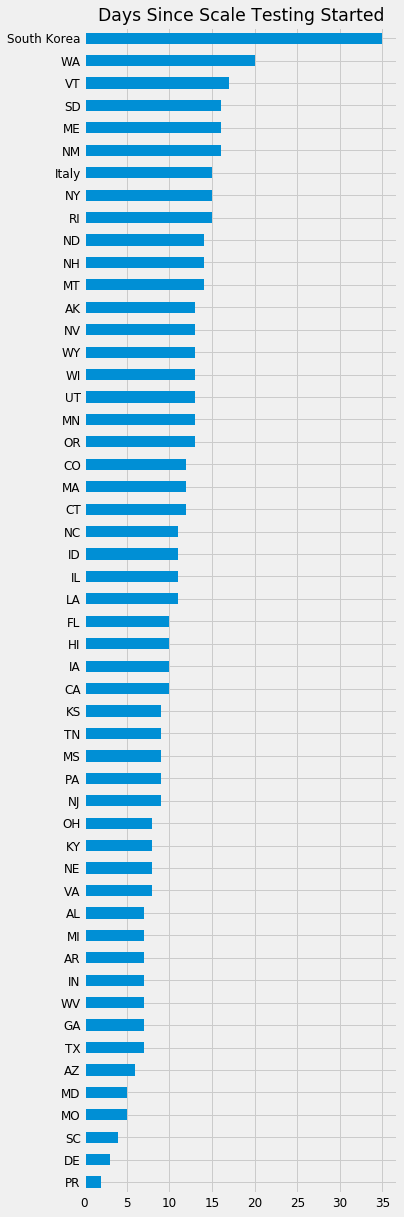

In [279]:
days_since_scale_tests = positive_since_testing.count().sort_values(ascending=True)
days_since_scale_tests.plot(kind='barh', figsize=(5,20), title = "Days Since Scale Testing Started")

In [280]:
import datetime as dt

def date_from_days_since(x):
    return (pd.to_datetime(daily_last_update)-dt.timedelta(days=x)).date()

date_since_scale_test = days_since_scale_tests.apply(date_from_days_since).sort_values()
fmt = "%Y-%m-%d"
date_since_scale_test.loc['WA'].strftime(fmt)

'2020-03-12'

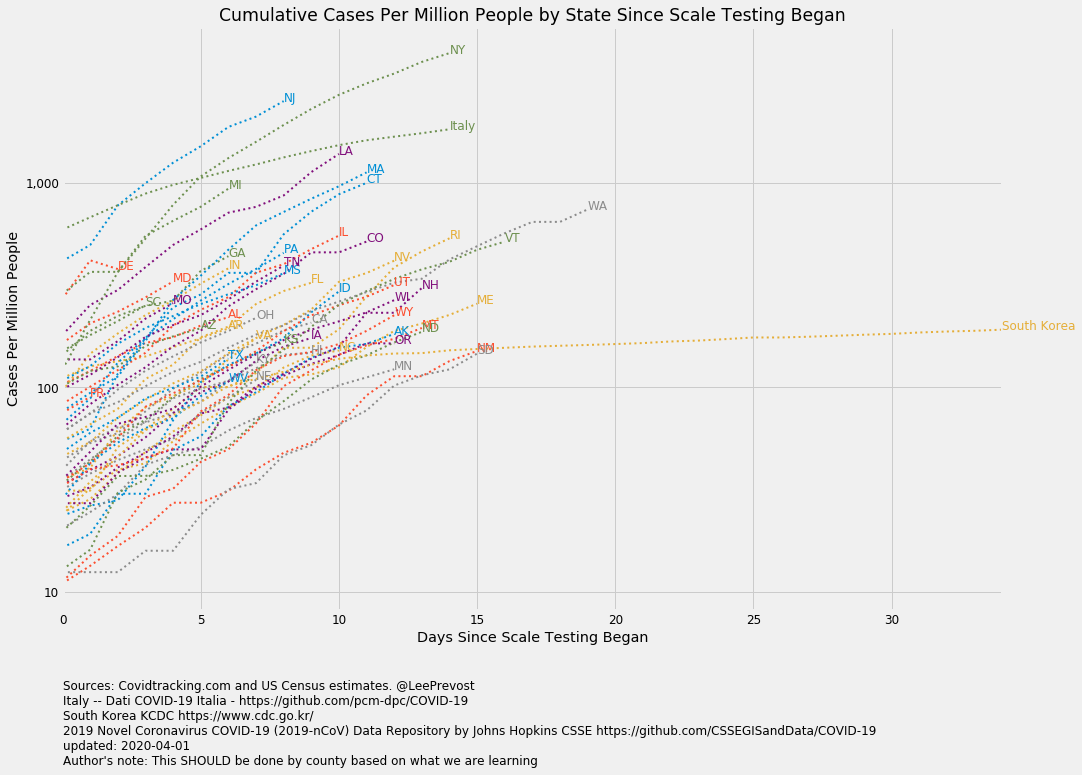

In [281]:
f, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({"font.size": 12})
#plt.style.use("seaborn")
lines = dict(legend=False, ax=ax, linewidth=2,logy=True, linestyle='dotted')

for (name, ser) in positive_since_testing.iteritems():
    l = ser.plot(label=name, **lines)
    x = ser.dropna().tail(1).index.values
    y = ser.dropna().tail(1).values   
    c = l.get_lines()[-1].get_color()
    s=name
    #s = name + "," + date_since_scale_test.loc[name].strftime(fmt)
    ax.annotate(s, (x,y), color = c)

    

ax.set_ylabel("Cases Per Million People")
ax.set_xlabel("Days Since Scale Testing Began")
note = """Sources: Covidtracking.com and US Census estimates. @LeePrevost
Italy -- Dati COVID-19 Italia - https://github.com/pcm-dpc/COVID-19
South Korea KCDC https://www.cdc.go.kr/
2019 Novel Coronavirus COVID-19 (2019-nCoV) Data Repository by Johns Hopkins CSSE https://github.com/CSSEGISandData/COVID-19
updated: {}
Author's note: This SHOULD be done by county based on what we are learning""".format(daily_last_update)
plt.annotate(note, (0,0), (0, -70), xycoords='axes fraction', textcoords='offset points', va='top')
title = "Cumulative Cases Per Million People by State Since Scale Testing Began"
plt.title(title)
ax.get_yaxis().set_major_formatter(
    tick.FuncFormatter(lambda x, p: format(int(x), ',')))
plt.savefig("{}.jpg".format(title), bbox_inches='tight')